In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms
import zookeeper as zk
import os
from tqdm import tqdm
from PIL import Image
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('spada e s' + str(device))

spada e scuda


In [3]:
class GalaxyJungle(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, mappy=False, is_rgb=False):
        self.rgb = is_rgb
        self.mappy = mappy
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        
    
    def __len__(self): return (self.img_labels).shape[0]

    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        image = Image.open(img_path)
        if not self.rgb: image = image.convert('L')
        if self.transform: image = self.transform(image)
        
        label = self.img_labels.iloc[idx, 1:]        
        label = torch.tensor(label.values, dtype=torch.float32)
        if self.mappy: label = zk.mappy(label)

        gal_id = self.img_labels.iloc[idx, 0]

        return image, label, gal_id

In [4]:
class GalaxyNet(nn.Module):
    def __init__(self, activation,mappy=False, initialization=False, is_rgb=False):
        super().__init__()
        self.mappy = mappy
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation

        
        ## convolutional layers
        ## convolutional layers
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 256 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()


    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        if self.mappy: x = zk.mappy2D(x)
        return x


    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)        

        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
 
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        

    def log_the_loss(self, item,epoch=False):
        train = self.__getstate__()['training']
        if epoch and train:
            self.loss_dict['epoch'].append(item)
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item

In [5]:
model = GalaxyNet(nn.LeakyReLU, initialization=False, mappy=False, is_rgb=False).to(device)
loss_function = nn.MSELoss()

### to resume training uncomment next lines
## NOTE: the loss_dict will be empty, remember which is the last loss_{}.pickle file of previous trainings to append the values all together
loader = torch.load('./padel.pt', weights_only=True)
model.load_state_dict(loader['model_state_dict'])

Convs output size: 2


<All keys matched successfully>

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(), # Riscala le immagini tra 0 e 1
    transforms.CenterCrop(324),
    transforms.Resize(128),
])

DS = GalaxyJungle('../data/test/test_solutions_rev1.csv', '../data/test/', transform, mappy=True, is_rgb=False)
test_loader = DataLoader(DS, batch_size=512, shuffle=False, num_workers=os.cpu_count())   

tens=torch.empty((0,18),dtype=torch.float32)

model.eval()
loss = 0
with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs,labels, GalaxyID = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = nn.ReLU()(outputs)
            outputs = zk.mappy2D(outputs)
            loss += np.sqrt(nn.MSELoss()(outputs, labels).item())
            GalaxyID = GalaxyID.unsqueeze(1)
            batch = torch.cat((GalaxyID,outputs.cpu()), dim=-1)
            tens = torch.cat((tens,batch),dim=0)
print('Test loss', loss/len(test_loader))


13it [00:03,  3.65it/s]

Test loss 0.060448818232772705


In [7]:
train_results = pd.DataFrame(tens, columns=['GalaxyID','E0','E3','E6','S0a_eon','SB0a_eon','Scd_eon','S0B','S0A','SAa','SAb','SAc','SAd','SBa','SBb','SBc','SBd','A'])
train_results[train_results < 0] = 0
train_results['GalaxyID'] = train_results['GalaxyID'].astype(int)
train_results.sort_values('GalaxyID', inplace=True, ignore_index=True)

true_results = zk.mappy_df(pd.read_csv('../data/test/test_solutions_rev1.csv'))
true_results.sort_values('GalaxyID', inplace=True, ignore_index=True)


train_results['train_label'] = train_results.iloc[:,1:].idxmax(axis=1)
train_results['train_value'] = train_results.iloc[:,1:-1].max(axis=1)

true_results['true_label'] = true_results.iloc[:,1:].idxmax(axis=1)
true_results['true_value'] = true_results.iloc[:,1:-1].max(axis=1)
#display(train_results)
#display(true_results)

/home/ubuntu/GCGIGI/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/ubuntu/GCGIGI/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


In [8]:
b=true_results.drop(columns=['true_label','true_value']).to_numpy()
l=[]
for i in b: 
    l.append(sorted(i, reverse=True)[:3])
    x=pd.DataFrame(l,columns=['GalaxyID','max1','max2'])
x['difference']=x['max1']-x['max2']
display(x)
true_results['difference']=x['difference'].values
display(true_results)
true_new = true_results[true_results['difference']>0.1]

,GalaxyID,max1,max2,difference
0,100078.0,0.408599,0.284778,0.123822
1,100128.0,0.482483,0.219246,0.263237
2,100143.0,0.561429,0.269843,0.291586
3,100335.0,0.166545,0.142823,0.023722
4,100367.0,0.445091,0.120398,0.324693
...,...,...,...,...
6153,998723.0,0.521740,0.150993,0.370747
6154,998735.0,0.337919,0.183078,0.154842
6155,999137.0,0.291163,0.280099,0.011064
6156,999569.0,0.706430,0.148617,0.557813


,GalaxyID,E0,E3,E6,S0a_eon,SB0a_eon,Scd_eon,S0B,S0A,SAa,...,SAc,SAd,SBa,SBb,SBc,SBd,A,true_label,true_value,difference
0,100078,0.408599,0.284778,0.000000,0.000000,0.000000,0.000000,0.022703,0.026763,0.053726,...,0.000000,0.000000,0.045577,0.041213,0.000000,0.000000,0.068059,E0,0.408599,0.123822
1,100128,0.482483,0.205300,0.000000,0.000000,0.000000,0.000000,0.069098,0.219246,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023873,E0,0.482483,0.263237
2,100143,0.000000,0.000000,0.269843,0.561429,0.000000,0.168728,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S0a_eon,0.561429,0.291586
3,100335,0.000000,0.123752,0.041251,0.078442,0.078442,0.078442,0.054902,0.166545,0.000000,...,0.066253,0.142823,0.000000,0.024849,0.021841,0.047082,0.000000,S0A,0.166545,0.023722
4,100367,0.026338,0.445091,0.000000,0.028662,0.000000,0.000000,0.097852,0.120398,0.023425,...,0.036923,0.038866,0.019038,0.038535,0.030009,0.031587,0.015863,E3,0.445091,0.324693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6153,998723,0.000000,0.150993,0.146879,0.057605,0.000000,0.000000,0.000000,0.521740,0.000000,...,0.089256,0.007240,0.000000,0.000000,0.000000,0.000000,0.005479,S0A,0.521740,0.370747
6154,998735,0.165318,0.183078,0.000000,0.036865,0.000000,0.000000,0.078735,0.337919,0.015795,...,0.039417,0.000000,0.003680,0.020329,0.009184,0.000000,0.022429,S0A,0.337919,0.154842
6155,999137,0.000000,0.000000,0.000000,0.018000,0.000000,0.000000,0.000000,0.000000,0.007594,...,0.199837,0.000000,0.011064,0.280099,0.291163,0.000000,0.000000,SBc,0.291163,0.011064
6156,999569,0.079528,0.706430,0.014624,0.049539,0.000000,0.000000,0.000000,0.148617,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001262,E3,0.706430,0.557813


In [9]:


#true_new = true_results
#true_new = true_results[true_results['true_value'] > 0.6]
#train_new=train_results[train_results['train_value']>0.4]
confronto=pd.merge(train_results[['GalaxyID','train_label']], true_new[['GalaxyID','true_label']], on='GalaxyID')
total_count=confronto.groupby('true_label').size().reset_index(name='total_count')
mislabels = confronto[confronto['train_label'] != confronto['true_label']]

count=mislabels.groupby('true_label').size().reset_index(name='num_misclassified').sort_values(by='num_misclassified', ascending=False)
final_count= pd.merge(total_count, count, on='true_label', how='left').sort_values(by='num_misclassified', ascending=False)
final_count['score'] = (np.round((1 - final_count['num_misclassified'] / final_count['total_count']),2)*100)
final_count.sort_values(by='score', ascending=False, inplace=True)
display(final_count)


,true_label,total_count,num_misclassified,score
1,E0,1064,48.0,95.0
2,E3,1182,138.0,88.0
9,SAc,337,59.0,82.0
6,S0a_eon,292,52.0,82.0
3,E6,170,48.0,72.0
15,Scd_eon,111,32.0,71.0
8,SAb,142,53.0,63.0
13,SBc,66,27.0,59.0
5,S0B,119,54.0,55.0
12,SBb,65,30.0,54.0



final_count.to_csv('padel110_06.txt', sep='&', index=False, lineterminator='\\\\\n')



In [10]:
x=confronto.groupby(['true_label','train_label']).count()
#pd.set_option('display.max_rows', None)
x

GalaxyID
true_label train_label          
A          A                   6
E0         A                   1
           E0               1016
           E3                 28
           S0A                17
...                          ...
Scd_eon    E6                 12
           S0A                 1
           S0a_eon            18
           SAc                 1
           Scd_eon            79

[93 rows x 1 columns]

In [11]:
y=confronto
all_classes = ['E0', 'E3','E6','S0A', 'S0B', 'SAa','SAb', 'SAc', 'SAd', 'SBa', 'SBb', 'SBc', 'SBd','S0a_eon', 'SB0a_eon', 'Scd_eon', 'A']
yy = y.groupby(['true_label', 'train_label']).size().reset_index(name='count')

all_in_column = set(all_classes).issubset(set(yy['true_label']))
print("All items in list are in the column:", all_in_column)
missing_true = set(all_classes) - set(yy['true_label'])
missing_train = set(all_classes) - set(yy['train_label'])
print(missing_true,missing_train)
for i in missing_true:
    for j in missing_train:
        yy = pd.concat([yy,pd.DataFrame([{'true_label': i, 'train_label': j, 'count': 0.1}])], ignore_index=True )



All items in list are in the column: False
{'SBa'} {'SB0a_eon', 'SBa', 'SAa'}


In [12]:
all_in_column = set(all_classes).issubset(set(yy['train_label']))

all_in_column

True

In [13]:
yy

,true_label,train_label,count
0,A,A,6.0
1,E0,A,1.0
2,E0,E0,1016.0
3,E0,E3,28.0
4,E0,S0A,17.0
...,...,...,...
91,Scd_eon,SAc,1.0
92,Scd_eon,Scd_eon,79.0
93,SBa,SB0a_eon,0.1
94,SBa,SBa,0.1


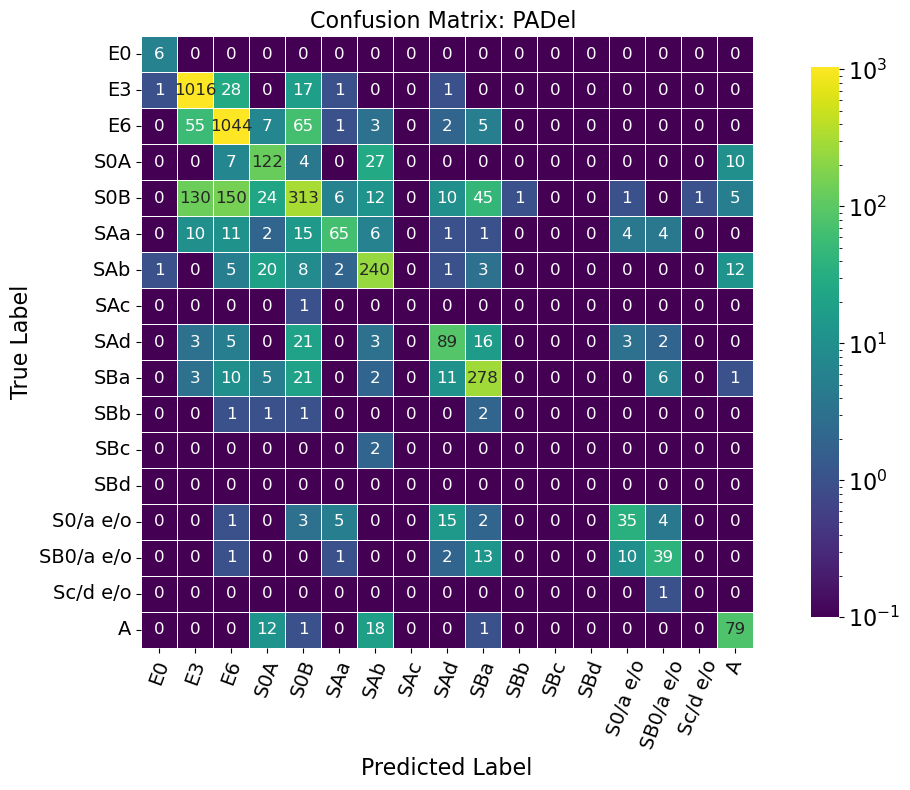

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

heatmap_data = yy.pivot(index='true_label', columns='train_label', values='count').fillna(0.1)
label_classes = all_classes#sorted(all_classes)
ticks = np.arange(0,17)+0.5
label_classes[13] = 'S0/a e/o'
label_classes[14] = 'SB0/a e/o'
label_classes[15] = 'Sc/d e/o'
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data,
                annot=True,
                annot_kws= {'fontsize': 12},
                fmt='.0f',
                cmap='viridis',
                norm= LogNorm(vmin=0.1, vmax=heatmap_data.values.max()),
                square=True,
                linewidths=0.4,
                cbar_kws={'label': 'Count', 'shrink':0.9}
                )
plt.title('Confusion Matrix: PADel ', fontsize=16)
plt.xticks(ticks=ticks,labels=label_classes,rotation=70)
plt.yticks(ticks=ticks,labels=label_classes,rotation=0)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

# Set colorbar label font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
ax.tick_params(labelsize=14)
cbar.set_label('', fontsize=16)
plt.tight_layout()
plt.savefig('confusion_matrix_padel_skimmed.png', dpi=500, bbox_inches='tight')
plt.show()

In [15]:
heatmap_data.shape

(17, 17)

In [16]:
all_classes = ['E0', 'E3','E6','S0A', 'S0B', 'S0a_eon', 'SB0a_eon', 'Scd_eon', 'SAa','SAb', 'SAc', 'SAd', 'SBa', 'SBb', 'SBc', 'SBd', 'A']
label_classes = sorted(all_classes)
label_classes[6] = 'S0/a\nEon'

In [17]:
## PADEL
def __init__(self, activation, initialization=False, is_rgb=False):
        super().__init__()
        
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation

        
        ## convolutional layers
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 256 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()


In [18]:

## NSVGG
    self.convs = nn.Sequential(
            ### conv 1
            nn.Conv2d(rgb, 64, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),
            

            ### conv 2
            nn.Conv2d(64, 128, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 128, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(128),
            
            nn.MaxPool2d(2),


            ### conv 3
            nn.Conv2d(128, 256, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(2),


            ### conv 4
            nn.Conv2d(256, 512, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(512),

            nn.MaxPool2d(2),


            ### conv 5
            nn.Conv2d(512, 512, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(512),

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 512 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 4096),
            self.activation(),
            nn.Linear(4096, 512),
            self.activation(),
            nn.Linear(512, 37)
            )
        
        if initialization: self.init_weights()


IndentationError: unexpected indent (4206359969.py, line 2)